In this notebook, we'll show how to use physics-informed neural networks (PINNs) to solve partial differential equations. Specifically, the DGLAP equation for the valence PDF in Mellin space.

**If using Colab**: Go to Runtime > Change Runtime Type.

Select a GPU or TPU if available. This will speed up training of the neural network.

**If running locally**: make sure you have [TensorFlow with GPU setup](https://www.tensorflow.org/install/pip).

In [ ]:
# Import some relevant libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set the seed
tf.random.set_seed(42)

# Neural Networks
A feed-forward, dense neural network a composition of linear functions:

$$A(\textbf{x}) = W\textbf{x} +\textbf{b}, $$

 and non-linear functions:

$$\sigma(\textbf{x}) = (\sigma(x_1), \sigma(x_2 ), ....\sigma(x_n )),$$

Specifically,

$$NN(\textbf{x}) =  A_n \circ \sigma  \circ  .... \circ A_2  \circ \sigma \circ A_1 (\textbf{x})$$

where each of the $A_i$'s have its own weight matrix $W_i$ and bias $\textbf{b}$_i. Instead of a composition of all functions, we can organize it as a sequence $\{\textbf{z}_i \}_{i=1}^n $ where $\textbf{z}_0 = x$:

$$\textbf{z}_{i+1} = \sigma \circ A_i (\textbf{z}_i)  =  \sigma( W_i \textbf{z}_{i} + \textbf{b}_i) \quad \quad (i=0, 1,...n-2),$$

and
$$NN(\textbf{x})=\textbf{z}_n = A_n (\textbf{z}_{n-1}) = W_n \textbf{z}_{n-1} + \textbf{b}_n    $$

The last layer is a linear transformation because in general $\sigma$ has a restricted domain.

Let's create a simple neural network with 3 'hidden layers' that takes in a 2D vector and spits out a 1D vector (i.e. a single number).

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

# Input layer
inputs = Input(shape=(2,))

# Hidden layers with GELU activation
x = Dense(8, activation='gelu')(inputs)
x = Dense(8, activation='gelu')(x)
x = Dense(8, activation='gelu')(x)

# Output layer
outputs = Dense(1, activation=None, name='output_layer')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

Visually, 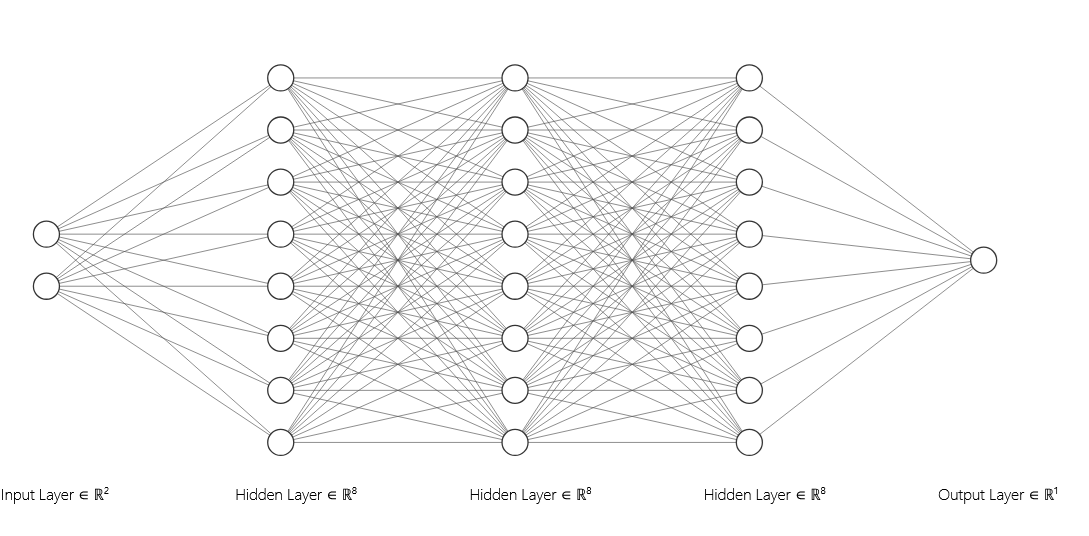

In the code, the line:

```python
inputs = Input(shape=(2,))
```
specifies that the input is a 2D vector.

```python
x = Dense(8, activation='gelu')(inputs)
```
The Dense function acts as the combination $\sigma \circ A$.
The first bracket pair are parameters for the Dense function. The 8 signifies the output dimension; the input dimension is inferred from the dimension of 'inputs'. The activation is 'gelu', the Gaussian error linear unit:

$$\mathrm{GELU}(x) = x \, \Phi(x)$$

where $\Phi (x)$ is the cumulative distribution function of the standard Gaussian (i.e, 0 mean, unit std). This has the advantage of being smooth (unlike the typically used ReLU) and doesn't suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

The second brackets is the actual input for the function.

In the last line,

```python
model = Model(inputs=inputs, outputs=outputs)
```
a model is created that starts with inputs, goes line by line, and finishes with ouputs.


Note: for model.summary() we see the ouput is of the form:
 ```python
(None, 8)
```
The 'None' is there because in training it's often useful work in 'batches' of data. That is, instead of putting in a single input vector of size (8,) at a time, when training it's faster to have the function work with, say, 64 inputs at a time. So, matrices of data get fed in with indices (64, 32), where the first index labels the data points. For our purposes, we can ignore it.

**Exercise 1.**: Explain the number of parameters in each layer in the model summary table.

*Solution*: The parameters are the weight matrix, W, and the bias. For the first layers, the incoming dimension is 2 and the outgoing is 8. Therefore the matrix has 8x2 =16 terms. The bias is 8 dimensional, therefore the total is 16+8=24. Similar logic holds for the other layers.

**Exercise 2.**: Make a general function that creates a neural network with the number of the layers and hidden neurons as input. The neural network should still have a 2D input, 1D output.

Create a neural network with 4 hidden layers, 64 hidden neurons each hidden layer, and name it 'model'.

In [ ]:
#Solution

def create_neural_network(hidden_units, num_hidden_layers):
    """
    Creates a fully connected neural network with:
    - Input shape: (2,)
    - Output shape: (1,)
    - GELU activation in hidden layers
    - No activation in the output layer

    Parameters:
    - hidden_units: int, number of units in each hidden layer.
    - num_hidden_layers: int, number of hidden layers.

    Returns:
    - model: a tf.keras.Model instance (uncompiled).
    """
    inputs = tf.keras.Input(shape=(2,))
    x = inputs

    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(hidden_units,
                                  activation=tf.keras.activations.gelu)(x)

    outputs = tf.keras.layers.Dense(1, activation=None, name='output_dense')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = create_neural_network(hidden_units=64, num_hidden_layers=4)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,737 (49.75 KB)

 Trainable params: 12,737 (49.75 KB)

 Non-trainable params: 0 (0.00 B)

# DGLAP Equations
The DGLAP ( Dokshitzer–Gribov–Lipatov–Altarelli–Parisi) equations give us how the parton distributions functions (PDFs) evolve with $Q^2$. The valence PDF is given by the flavor PDF substracted the anti-flavor PDF: $f_v = f - \bar{f}$ (e.g. for the up: $u_v = u -\bar{u}$). Then, the evolution equation for $f_v$ is:

$$Q^2 \frac{\partial f_v(x,Q^2)}{\partial Q^2} = \frac{\alpha_S(Q^2)}{2\pi}\int_x^1 \frac{dz}{z} P_{qq} (z) f_v \big(\frac{x}{z}, Q^2 \big)  \tag{1}$$


Working with a integro-differential equations can be difficult. This can be transformed into a PDE with a Mellin transform:

$$\hat{f}_v (s, Q^2) = \int_0^1 dx x^{s-1} f_v(x,Q^2)$$

Note: some sources define it with a $s$ rather than an $s-1$.

Then we get the evolution in Mellin space:

$$\boxed{Q^2 \frac{\partial \hat{f}_v(s, Q^2) }{\partial Q^2} = \frac{\alpha_S(Q^2) }{2\pi} \gamma_{qq}(s)  \hat{f}_v(s, Q^2)} \tag{2} $$

Here anomalous dimension is defined as:
$$\gamma_{qq}(s) = \int_0^1 dz z^{s-1} P_{qq}(z)  $$

To lowest order:
$$\gamma_{qq}(s) =  C_F \bigg[ \frac{3}{2} + \frac{1}{s(s+1)}  -2\psi(s+1) + 2\psi(1)  \bigg]  \tag{3}$$

where $C_F = \frac{N_C^2-1}{2N_C}$ ($N_C=3$ is the number of colors for QCD) and $\psi(s)$ is the digamma function.

The solution to Eq. (2) is analytic:

$$\hat{f}_v(s, Q^2) = \exp \bigg( \int_{Q_0^2}^{Q^2} \frac{dQ'^2}{Q'^2} \frac{\alpha_S(Q^2) }{2\pi}    \gamma_{qq}(s)  \bigg) \hat{f}(s, Q_0^2) $$



**Exercise 3**.: Get Eq. (2) from Eq. (1).

Solution.

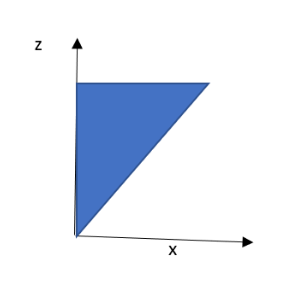


$$\int_0^1 dx x^{s-1}  \int_x^1 \frac{dz}{z} P_{qq} (z) f_v \big(\frac{x}{z}, Q^2 \big) = \int_0^1 \frac{dz}{z}  P_{qq} (z)   \int_0^z  dx x^{s-1} f_v \big(\frac{x}{z}, Q^2 \big)$$

Do a change of variables in the x integral, $y = \frac{x}{z}$:

\begin{align}
&= \int_0^1 dz z^{s-1} P_{qq} (z)   \int_0^1 dy y^{s-1}  f_v \big(y, Q^2 \big)  \\
& = \gamma_{qq} (s)   \hat{f}_v \big(s, Q^2 \big)
\end{align} □




To lowest order, the strong coupling is given by:
$$\alpha_S(Q^2) = \frac{1}{\beta_1 \ln (Q^2/\Lambda^2 ) } $$
where
$$\beta_1 = (11N_c -2N_f)/12\pi, $$
and $N_f$ is the number of flavors.

For this exercise we'll use the PDF set CJ15, a CTEQ-Jefferson Lab collaboration. The CJ15 set has five flavors, but there is actually some complication about the number of active flavors for a given $Q^2$. That is, for $Q^2 < m_B^2$ the bottom quark isn't active.  We'll ignore this and not include the bottom quark for now: $N_f = 4$. We'll have a $
\Lambda$ value corresponding to 4 active quarks (see [here](https://lhapdfsets.web.cern.ch/current/CJ15nlo/CJ15nlo.info)):

$$\Lambda = \Lambda_4^{CJ15} = 0.385 \ GeV $$.

For the integral inside the exponential,


$$\hat{f}(s, Q^2) = \exp \bigg[ \frac{1}{2\pi \beta_1} \ln \bigg( \frac{\ln (Q^2/\Lambda^2 )}{\ln (Q_0^2/\Lambda^2 )} \bigg)  \gamma_{qq}(s)  \bigg] f(s, Q_0^2) $$

$$
\boxed{
\hat{f}(s, Q^2) = \left( \frac{\ln (Q^2/\Lambda^2 )}{\ln (Q_0^2/\Lambda^2 )} \right)^{\frac{\gamma_{qq}(s)}{2\pi\beta_1}}  f(s, Q_0^2)
} \tag{5}
$$

For this exercise, we'll use the up valence from [CJ15](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.114017). The parameterization is:

$$u_v(x, Q_0^2) = a_0\, x^{a_1 - 1} (1 - x)^{a_2} \left(1 + a_3 x^{1/2} + a_4 x\right)$$

Note: by default PDFs refer to partons in the proton. By isospin symmetry, this can be related to partons in the neutron.

We'll use the central values of the parameters:
$$ \begin{align*}
a_0 &= 2.406 \\
a_1 &= 0.61537 \\
a_2 &= 3.5433 \\
a_3 &= 0 \\
a_4 &= 3.4609
\end{align*}
$$
along with:
$$Q_0^2 = m_C^2 = 1.69 \ GeV^2 $$




Analytically, we can take the Mellin transform of CJ15's $u_v(x,Q_0^2)$  using the Beta function :
$$ B(x, y) = \int_0^1 dt \  t^{x -1} (1-t)^{y-1}  $$
We get:
$$u_v(s , Q_0^2 ) = a_0 \left[
B( s+ a_1 - 1, a_2 + 1) +
a_3 B\left( s+ a_1 - \tfrac{1}{2}, a_2 + 1\right) +
a_4 B( s+ a_1, a_2 + 1)
\right]
$$

In [ ]:
from scipy.special import beta


# Parameters
a_0 = 2.406
a_1 = 0.61537
a_2 = 3.5433
a_3 = 0
a_4 = 3.4609

# Starting scale
Q_02 = 1.3**2  # GeV^2

def u_v_0_Mellin(s):
    # Mellin transform of CJ15's u_val at Q_0^2
    term1 = beta(s + a_1-1, a_2 + 1)
    term2 = a_3 * beta(s + a_1 - 0.5, a_2 + 1)
    term3 = a_4 * beta(s + a_1 , a_2 + 1)
    return a_0 * (term1 + term2 + term3)

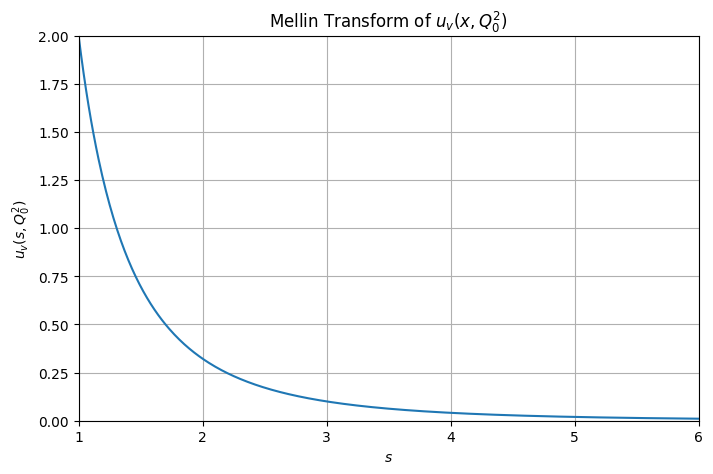

In [ ]:
#Plot the function

# s values from 1 to 10
s_values = np.linspace(1, 6, 500)
mellin_values = u_v_0_Mellin(s_values)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(s_values, mellin_values)
plt.xlabel(r'$s$')
plt.title('Mellin Transform of $u_v(x, Q_0^2)$')
plt.ylabel(r'$u_v(s, Q_0^2)$')
plt.xlim(1,6)
plt.ylim(0,2)
plt.grid(True)
plt.show()

**Exercise 4**: What is the value of $\hat{u}_v(1, Q)$? Why?

*Solution*: the 'upness' of the proton is 2, so $\hat{u}_v(1, Q^2) = \int_0^1 dx u_v(x,Q^2) = 2$.

We can plot $u_v(s, Q^2)$ using Eq.(5).

In [ ]:
from scipy.special import digamma

# More parameters
Lambda_4 = 0.385   # GeV
Q_02     = 1.69    # GeV^2
N_c      = 3       # QCD colors
N_f      = 4       # Number of active flavors
beta_1   = (11*N_c - 2*N_f)/(12*np.pi)
C_F      =  (N_c**2-1)/(2*N_c)  #Casimir of fundamental group

# Create useful functions
def anamolous_dimension(s):
  # Gives anamolous dimension for Mellin variable s
  return  C_F*(1.5 + 1/((s)*(s+1.))-2.*digamma(s+1.) + 2.*digamma(1))

def u_v_Mellin(s,Q):
  # Up valence at arbitiary (s,Q)
  Q_term    = (np.log(Q**2/Lambda_4**2))/np.log(Q_02/Lambda_4**2)
  exponent  = anamolous_dimension(s)/(2.*np.pi*beta_1)

  return u_v_0_Mellin(s)*(Q_term)**(exponent)

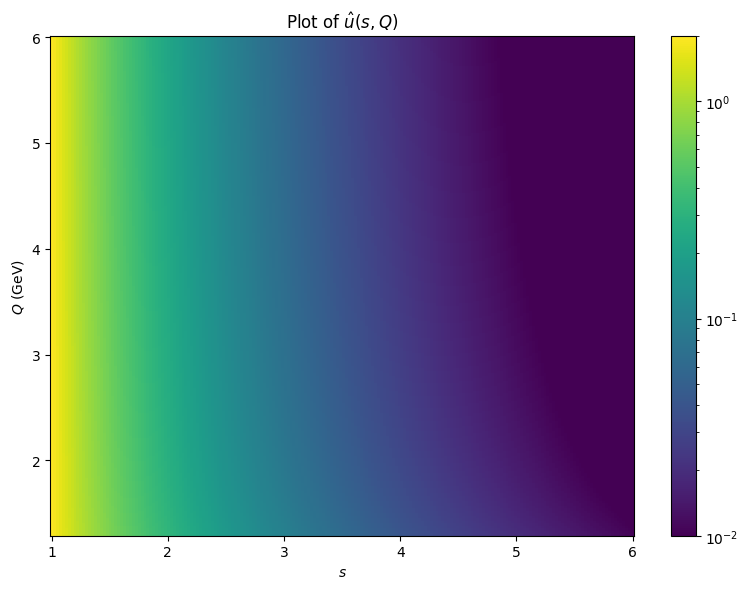

In [ ]:
from matplotlib.colors import LogNorm

# Grid for s and Q
s_vals = np.linspace(1, 6, 200)
Q_vals = np.linspace(1.3, 6, 200)
S, Q = np.meshgrid(s_vals, Q_vals)

# Compute function values
Z = u_v_Mellin(S, Q)

# Plotting with fixed colorbar range
plt.figure(figsize=(8, 6))
c = plt.pcolormesh(S, Q, Z, shading='auto', cmap='viridis',
                   norm=LogNorm(vmin=1e-2, vmax=2))
plt.colorbar(c)
plt.xlabel(r'$s$')
plt.ylabel(r'$Q$ (GeV)')
plt.title(r'Plot of $\hat{u}(s, Q)$')
plt.tight_layout()
plt.show()

# Physics-Informed Neural Networks

Physics-informed neural networks (PINNs), introduced in [2019](https://www.sciencedirect.com/science/article/pii/S0021999118307125), use the fact that for neural networks derivatives can be taken exactly and quickly. They are a numerical method to solve partial differential equations (PDE's).

For a PINN the parameters are fitted by trying to minimize the loss function:

$$L = L_{BC} + L_{PDE} \tag{6}$$

The first term tells the neural network to fit the boundary conditions at a finite number of points. For us, we'll take $\hat{u}_v(s, Q_0^2)$ as given and we use the contraint $\hat{u}_v(s=1, Q^2) = 2$.

$$L_{BC}= \sum_{i=1}^{N_1^{BC}} |f(s_i, Q_0^2)-\hat{u}_v(s_i, Q_0^2)|^2  +  \sum_{i=1}^{N_2^{BC}} |f(1, Q_i)-2|^2 $$

The second term, tells the neural network to try to the follow DGLAP PDE at some points:

$$L_{PDE} = \sum_{i=1}^{N_{PDE}} \bigg| Q_i^2 \frac{\partial f(s_i, Q_i^2) }{\partial Q_i^2} - \frac{\alpha_S(Q_i^2) }{2\pi} \gamma_{qq}(s_i)  f(s_i, Q_i^2)\bigg|^2 $$


Below is the code to fit the neural network trying to the minimize the loss function in Eq. (6).

In [ ]:
import numpy as np
import tensorflow as tf

# Define some useful functins

def beta_tf(x, y):
    # Computes Beta(x, y) using log-gamma identities for stability
    return tf.exp(tf.math.lgamma(x) + tf.math.lgamma(y) - tf.math.lgamma(x + y))

def alpha_s_qcd(Q, Lambda_4=0.385, beta_1=(11*3 - 2*4)/(12*np.pi)):
    """
    Calculates the strong coupling constant alpha_s at lowest order.

    Parameters:
    - Q: TensorFlow tensor, the energy scale (GeV).
    - Lambda_4: float, Lambda parameter for 4 active flavors (GeV).
    - beta_1: float,  (11N_C-2N_f)/12pi.

    Returns:
    - alpha_s: TensorFlow tensor, the value of alpha_s.
    """
    # Ensure Q, Lambda_4, beta_1 are tf variables
    Q = tf.cast(Q, tf.float32)
    Lambda_4 = tf.constant(Lambda_4, dtype=tf.float32)
    beta_1 = tf.constant(beta_1, dtype=tf.float32)

    log_term = tf.math.log(tf.square(Q) / tf.square(Lambda_4))
    alpha_s = 1.0 / (beta_1 * log_term)

    return alpha_s

def anamolous_dimension_tf(s, C_F=1.5):
    """
    Calculates the anomalous dimension gamma_qq(s) using TensorFlow.

    Parameters:
    - s: TensorFlow tensor, the Mellin variable.
    - C_F: float, Casimir invariant: (N_C^2-1)/2N_C^2.

    Returns:
    - gamma_qq: TensorFlow tensor, the value of gamma_qq(s).
    """
    # Ensure s, C_F are tf variables
    s = tf.cast(s, tf.float32)
    C_F = tf.constant(C_F, dtype=tf.float32)

    # Digramma terms
    term_psi = tf.math.digamma(s + 1.0) - tf.math.digamma(1.0)

    gamma_qq = C_F * (1.5 + 1.0 /(s*(s+1.)) - 2.0 * term_psi)
    return gamma_qq

def u_v_0_Mellin_tf(s, a_0=2.4067, a_1=0.61537, a_2=3.5433, a_3=0, a_4=3.4609):
    # Turn input into tf variables
    s = tf.cast(s, tf.float32)
    a_0, a_1, a_2, a_3, a_4 = [tf.constant(val, dtype=tf.float32) for val in [a_0, a_1, a_2, a_3, a_4]]

    term1 = beta_tf(s + a_1-1, a_2 + 1.0)
    term2 = a_3 * beta_tf(s + a_1 - 0.5, a_2 + 1.0)
    term3 = a_4 * beta_tf(s + a_1, a_2 + 1.0)

    return a_0 * (term1 + term2 + term3)

def pde_loss(model, inputs):
    """
    Calculates the loss based on the DGLAP partial differential equation.

    Parameters:
    - model: tf.keras.Model, the neural network predicting f(s, Q^2).
    - inputs: TensorFlow tensor of shape (None, 2), containing [s, Q^2] pairs.

    Returns:
    - pde_loss_value: TensorFlow scalar, the mean squared error of the PDE residual.
    """
    s = inputs[:, 0:1]  # Shape (None, 1)
    Q = inputs[:, 1:2]  # Shape (None, 1)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(s)
        tape.watch(Q)

        # The model predicts f(s, Q^2)
        f_pred = model(tf.stack([s[:,0], Q[:,0]], axis=1)) # Model expects shape (None, 2)

        # Calculate partial derivative of f_pred with respect to Q^2
        # The input to the model is Q, we need the derivative w.r.t Q^2
        # df/d(Q^2) = (df/dQ) * (1 / (2*Q))
        df_dQ = tape.gradient(f_pred, Q)
        df_dQ_squared = df_dQ / (2.0 * Q + tf.keras.backend.epsilon()) # Add epsilon for numerical stability

        # PDE LHS: Q^2 * df/d(Q^2)
        pde_lhs = tf.square(Q) * df_dQ_squared

        # PDE RHS: (alpha_s(Q^2) / (2*pi)) * gamma_qq(s) * f(s, Q^2)
        alpha_s = alpha_s_qcd(Q)
        gamma_qq = anamolous_dimension_tf(s)

        # Reshape gamma_qq to match f_pred if necessary (gamma_qq depends only on s)
        # Ensure shapes are compatible for element-wise multiplication
        pde_rhs = (alpha_s / (2.0 * np.pi)) * gamma_qq * f_pred

    # Release the tape resources
    del tape

    # PDE Residual: LHS - RHS
    pde_residual = pde_lhs - pde_rhs

    # PDE Loss: Mean squared error of the residual
    pde_loss_value = tf.reduce_mean(tf.square(pde_residual))

    return pde_loss_value

def boundary_condition_loss(model, Q02_s_points, s0_Q_points, Q_02=1.69):
    """
    Calculates the loss based on the boundary conditions at Q^2=Q0^2 and s=1.

    Parameters:
    - model: tf.keras.Model, the neural network predicting f(s, Q^2).
    - Q02_s_points: TensorFlow tensor of shape (None, 2), containing [s, Q0^2] pairs.
    - s0_Q_points: TensorFlow tensor of shape (None, 2), containing [1, Q^2] pairs.
    - Q_02: float, the reference scale Q0^2.

    Returns:
    - bc_loss_value: TensorFlow scalar, the mean squared error of the BC residual.
    """
    ### Q_0^2 Boundary
    s_Q02 = Q02_s_points[:, 0:1] # Shape (None, 1)
    # Q_Q02 is already Q0^2, but keep for consistency
    Q_at_Q02 = Q02_s_points[:, 1:2] # Shape (None, 1)

    f_pred_Q02 = model(tf.stack([s_Q02[:,0], Q_at_Q02[:,0]], axis=1)) # Model expects shape (None, 2)
    u_v_target_Q02 = u_v_0_Mellin_tf(s_Q02)

    bc_residual_Q02 = f_pred_Q02 - u_v_target_Q02
    bc_loss_Q02 = tf.reduce_mean(tf.square(bc_residual_Q02))

    ### s=1 Boundary
    s_at_s0 = s0_Q_points[:, 0:1] # Shape (None, 1)
    Q_s0 = s0_Q_points[:, 1:2] # Shape (None, 1)

    f_pred_s0 = model(tf.stack([s_at_s0[:,0], Q_s0[:,0]], axis=1)) # Model expects shape (None, 2)
    u_v_target_s0 = tf.ones_like(f_pred_s0) * 2.0 # Target is always 2

    bc_residual_s0 = f_pred_s0 - u_v_target_s0
    bc_loss_s0 = tf.reduce_mean(tf.square(bc_residual_s0))

    # Total BC loss
    bc_loss_value = bc_loss_Q02 + bc_loss_s0

    return bc_loss_value

def total_loss(model, pde_points, Q02_s_points, s0_Q_points):
    """
    Calculates the total loss for the PINN, combining PDE and boundary conditions.

    Parameters:
    - model: tf.keras.Model, the neural network predicting f(s, Q^2).
    - pde_points: TensorFlow tensor of shape (None, 2), points for PDE loss ([s, Q]).
    - Q02_s_points: TensorFlow tensor of shape (None, 2), points for BC loss at Q^2=Q0^2 ([s, Q0^2]).
    - s0_Q_points: TensorFlow tensor of shape (None, 2), points for BC loss at s=1 ([1, Q]).

    Returns:
    - total_loss_value: TensorFlow scalar, the sum of PDE and BC losses.
    """
    pde_loss_val = pde_loss(model, pde_points)
    bc_loss_val = boundary_condition_loss(model, Q02_s_points, s0_Q_points)
    total_loss_value = pde_loss_val + bc_loss_val
    return total_loss_value, pde_loss_val, bc_loss_val

@tf.function
def train_step(model, optimizer, pde_points, Q02_s_points, s0_Q_points):
    """
    Performs a single training step for the PINN.

    Parameters:
    - model: tf.keras.Model, the neural network.
    - optimizer: tf.keras.optimizers.Optimizer, the optimizer.
    - pde_points: TensorFlow tensor, points for PDE loss.
    - Q02_s_points: TensorFlow tensor, points for BC loss at Q0^2.
    - s0_Q_points: TensorFlow tensor, points for BC loss at s=1.

    Returns:
    - loss: TensorFlow scalar, the total loss for this step.
    - pde_loss_val: TensorFlow scalar, the PDE loss for this step.
    - bc_loss_val: TensorFlow scalar, the BC loss for this step.
    """
    with tf.GradientTape() as tape:
        loss, pde_loss_val, bc_loss_val = total_loss(model, pde_points,
                                                     Q02_s_points, s0_Q_points)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, pde_loss_val, bc_loss_val


In [ ]:
# Define number of points for training
num_pde_points = 5000
num_bc_q02_points = 50
num_bc_s0_points = 50

# Generate training points
# For PDE points: sample s and Q within a relevant range
s_pde = tf.random.uniform((num_pde_points, 1), minval=1.0, maxval=6.0)
Q_pde = tf.random.uniform((num_pde_points, 1), minval=np.sqrt(Q_02), maxval=6.0)
pde_points = tf.concat([s_pde, Q_pde], axis=1)

# For BC points at Q^2 = Q0^2: sample s, while Q is fixed to sqrt(Q0^2)
s_bc_q02 = tf.random.uniform((num_bc_q02_points, 1), minval=1.0, maxval=6.0)
Q_bc_q02 = tf.constant(np.sqrt(Q_02), shape=(num_bc_q02_points, 1),
                       dtype=tf.float32)
Q02_s_points = tf.concat([s_bc_q02, Q_bc_q02], axis=1)

# For BC points at s = s0: sample Q, s is fixed to 1
s_bc_s0 = tf.constant(1.0, shape=(num_bc_s0_points, 1), dtype=tf.float32)
Q_bc_s0 = tf.random.uniform((num_bc_s0_points, 1), minval=np.sqrt(Q_02), maxval=6.0)
s0_Q_points = tf.concat([s_bc_s0, Q_bc_s0], axis=1)

# Choose an optimizer and learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training loop
epochs = 10_000

for epoch in range(epochs):
    total_loss_val, pde_loss_val, bc_loss_val = train_step(model, optimizer, pde_points, Q02_s_points, s0_Q_points)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss_val.numpy():.4e}, PDE Loss: {pde_loss_val.numpy():.4e}, BC Loss: {bc_loss_val.numpy():.4e}")

print("\nTraining finished.")

Epoch 0, Total Loss: 4.4706e+00, PDE Loss: 2.6681e-02, BC Loss: 4.4439e+00
Epoch 100, Total Loss: 4.1565e-02, PDE Loss: 7.9282e-03, BC Loss: 3.3637e-02
Epoch 200, Total Loss: 9.3618e-03, PDE Loss: 1.8779e-03, BC Loss: 7.4839e-03
Epoch 300, Total Loss: 3.5384e-03, PDE Loss: 7.9020e-04, BC Loss: 2.7482e-03
Epoch 400, Total Loss: 1.7828e-03, PDE Loss: 4.4256e-04, BC Loss: 1.3403e-03
Epoch 500, Total Loss: 1.0979e-03, PDE Loss: 2.8431e-04, BC Loss: 8.1357e-04
Epoch 600, Total Loss: 1.2857e-03, PDE Loss: 1.9140e-04, BC Loss: 1.0943e-03
Epoch 700, Total Loss: 5.7602e-04, PDE Loss: 1.5699e-04, BC Loss: 4.1904e-04
Epoch 800, Total Loss: 4.7248e-04, PDE Loss: 1.2887e-04, BC Loss: 3.4362e-04
Epoch 900, Total Loss: 4.0024e-04, PDE Loss: 1.0879e-04, BC Loss: 2.9145e-04
Epoch 1000, Total Loss: 3.3778e-04, PDE Loss: 9.3975e-05, BC Loss: 2.4381e-04
Epoch 1100, Total Loss: 2.9349e-04, PDE Loss: 7.9738e-05, BC Loss: 2.1376e-04
Epoch 1200, Total Loss: 2.6376e-04, PDE Loss: 7.3865e-05, BC Loss: 1.8990e-0

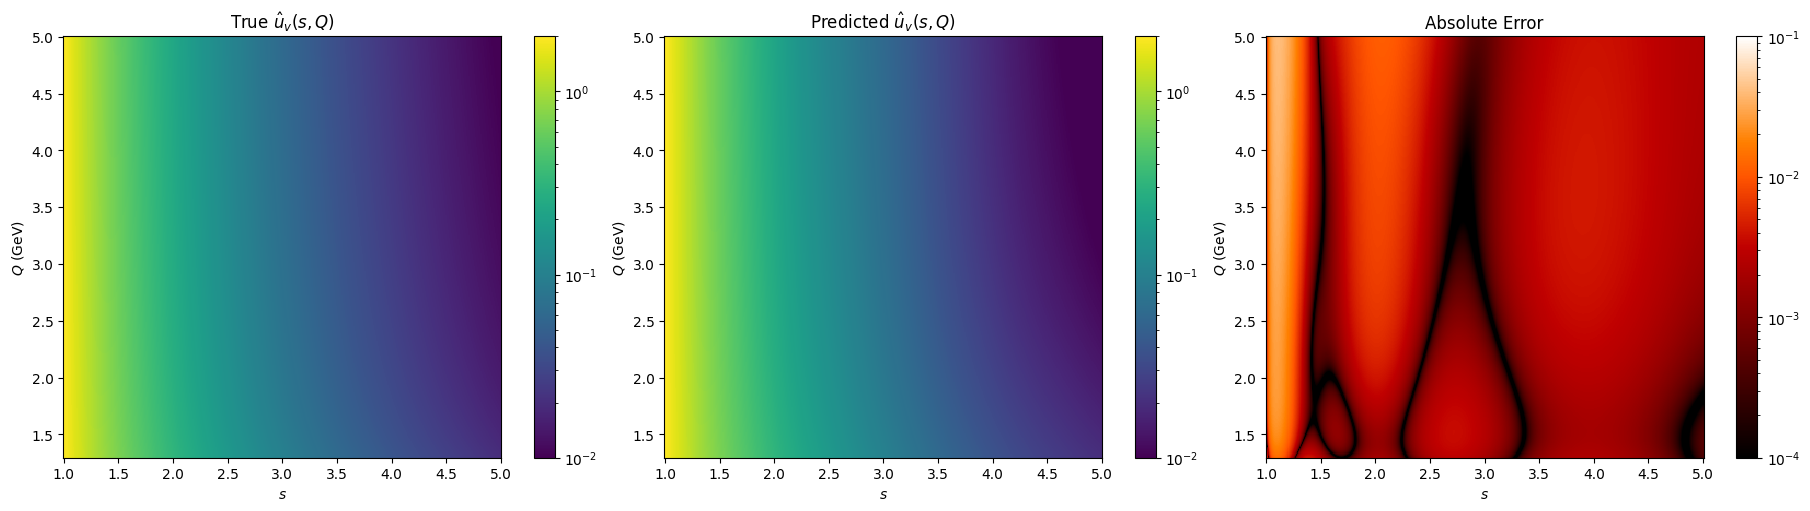

In [ ]:
from matplotlib.colors import LogNorm

# Grid for s and Q
s_vals = np.linspace(1, 5, 400)
Q_vals = np.linspace(1.3, 5, 400)
S, Q = np.meshgrid(s_vals, Q_vals)

# Compute true function values
Z = u_v_Mellin(S, Q)  # shape (200, 200)

# Predictions
# Prepare input data for model: flatten and stack S and Q as (N, 2)
S_flat = S.flatten()
Q_flat = Q.flatten()
inputs = tf.convert_to_tensor(np.stack([S_flat, Q_flat], axis=1),
                              dtype=tf.float32)

# Predict using the trained model
Z_pred_flat = model(inputs).numpy().flatten()

# Reshape back to the original 2D shape
Z_pred = Z_pred_flat.reshape(S.shape)

# Compute absolute error and max for scaling plot
Z_error = np.abs(Z - Z_pred)
max_abs_err = np.max(np.abs(Z_error))

# Set color scale so that pred. and true graph are the same
vmin = 1e-2
vmax = 2

fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 1. True function
pcm1 = axs[0].pcolormesh(S, Q, Z, shading='auto', cmap='viridis',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
axs[0].set_title('True $\\hat{u}_v(s, Q)$')
axs[0].set_xlabel('$s$')
axs[0].set_ylabel('$Q$ (GeV)')

# 2. Predicted function
pcm2 = axs[1].pcolormesh(S, Q, Z_pred, shading='auto', cmap='viridis',
                         norm=LogNorm(vmin=vmin, vmax=vmax))
axs[1].set_title('Predicted $\\hat{u}_v(s, Q)$')
axs[1].set_xlabel('$s$')
axs[1].set_ylabel('$Q$ (GeV)')

# 3. Error
pcm3 = axs[2].pcolormesh(S, Q, Z_error, shading='auto', cmap='gist_heat',
                         norm=LogNorm(vmin=1e-4, vmax=1e-1)
                         )
axs[2].set_title('Absolute Error')
axs[2].set_xlabel('$s$')
axs[2].set_ylabel('$Q$ (GeV)')

# Add colorbars for each plot
fig.colorbar(pcm1, ax=axs[0])
fig.colorbar(pcm2, ax=axs[1])
fig.colorbar(pcm3, ax=axs[2])

plt.show()

**Exercise 5**: Keeping the number of training of epochs the same as before, find a way to improve predictions. Specifically, play with the neural network. You can vary the number of hidden neurons, hidden layers, etc.

*Solution*: one way would be to go 'deeper' with more hidden layers. This is good for image data, where there is many different scales to images. However, for many physics functions, this isn't the case and it's often better to go 'wide'. That is, increase the number of neurons.

In [ ]:
import tensorflow as tf

# Parameters
epochs = 10_000
initial_lr = 1e-3
boundaries = [epochs // 4, epochs // 2, 3 * epochs // 4]
values = [initial_lr, initial_lr , initial_lr, initial_lr]

# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)

# Optimizer with schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Create model
model2 = create_neural_network(hidden_units=32, num_hidden_layers=4)
model2.summary()

# --- Build optimizer by running one dummy gradient step ---
with tf.GradientTape() as tape:
    dummy_input = tf.convert_to_tensor(pde_points)
    dummy_output = model2(dummy_input)
    dummy_loss = tf.reduce_mean(dummy_output)
grads = tape.gradient(dummy_loss, model2.trainable_variables)
optimizer.apply_gradients(zip(grads, model2.trainable_variables))

# --- Define train_step only ONCE, outside the loop ---
@tf.function(reduce_retracing=True)
def train_step(model, optimizer, pde_points, Q02_s_points, s0_Q_points):
    with tf.GradientTape() as tape:
        total_loss_val, pde_loss_val, bc_loss_val = total_loss(
            model, pde_points, Q02_s_points, s0_Q_points
        )
    gradients = tape.gradient(total_loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss_val, pde_loss_val, bc_loss_val

# --- Training loop ---
for epoch in range(epochs):
    total_loss_val, pde_loss_val, bc_loss_val = train_step(
        model2, optimizer, pde_points, Q02_s_points, s0_Q_points
    )

    if epoch % 100 == 0:
        current_lr = lr_schedule(epoch).numpy()
        print(f"Epoch {epoch}, LR: {current_lr:.1e}, Total Loss: {total_loss_val.numpy():.4e}, PDE Loss: {pde_loss_val.numpy():.4e}, BC Loss: {bc_loss_val.numpy():.4e}")

print("\nTraining finished.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,297 (12.88 KB)

 Trainable params: 3,297 (12.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 0, LR: 1.0e-03, Total Loss: 5.9811e+00, PDE Loss: 1.1408e-01, BC Loss: 5.8670e+00
Epoch 100, LR: 1.0e-03, Total Loss: 1.8599e-01, PDE Loss: 4.9437e-02, BC Loss: 1.3655e-01
Epoch 200, LR: 1.0e-03, Total Loss: 4.6863e-02, PDE Loss: 1.4110e-02, BC Loss: 3.2753e-02
Epoch 300, LR: 1.0e-03, Total Loss: 1.5460e-02, PDE Loss: 4.3852e-03, BC Loss: 1.1075e-02
Epoch 400, LR: 1.0e-03, Total Loss: 6.0350e-03, PDE Loss: 1.8044e-03, BC Loss: 4.2306e-03
Epoch 500, LR: 1.0e-03, Total Loss: 3.0078e-03, PDE Loss: 9.3181e-04, BC Loss: 2.0760e-03
Epoch 600, LR: 1.0e-03, Total Loss: 1.8050e-03, PDE Loss: 5.7890e-04, BC Loss: 1.2261e-03
Epoch 700, LR: 1.0e-03, Total Loss: 1.2129e-03, PDE Loss: 4.0205e-04, BC Loss: 8.1086e-04
Epoch 800, LR: 1.0e-03, Total Loss: 1.6413e-03, PDE Loss: 2.6019e-04, BC Loss: 1.3811e-03
Epoch 900, LR: 1.0e-03, Total Loss: 6.6538e-04, PDE Loss: 2.3623e-04, BC Loss: 4.2915e-04
Epoch 1000, LR: 1.0e-03, Total Loss: 6.2281e-04, PDE Loss: 1.8025e-04, BC Loss: 4.4255e-04
Epoch 1100,

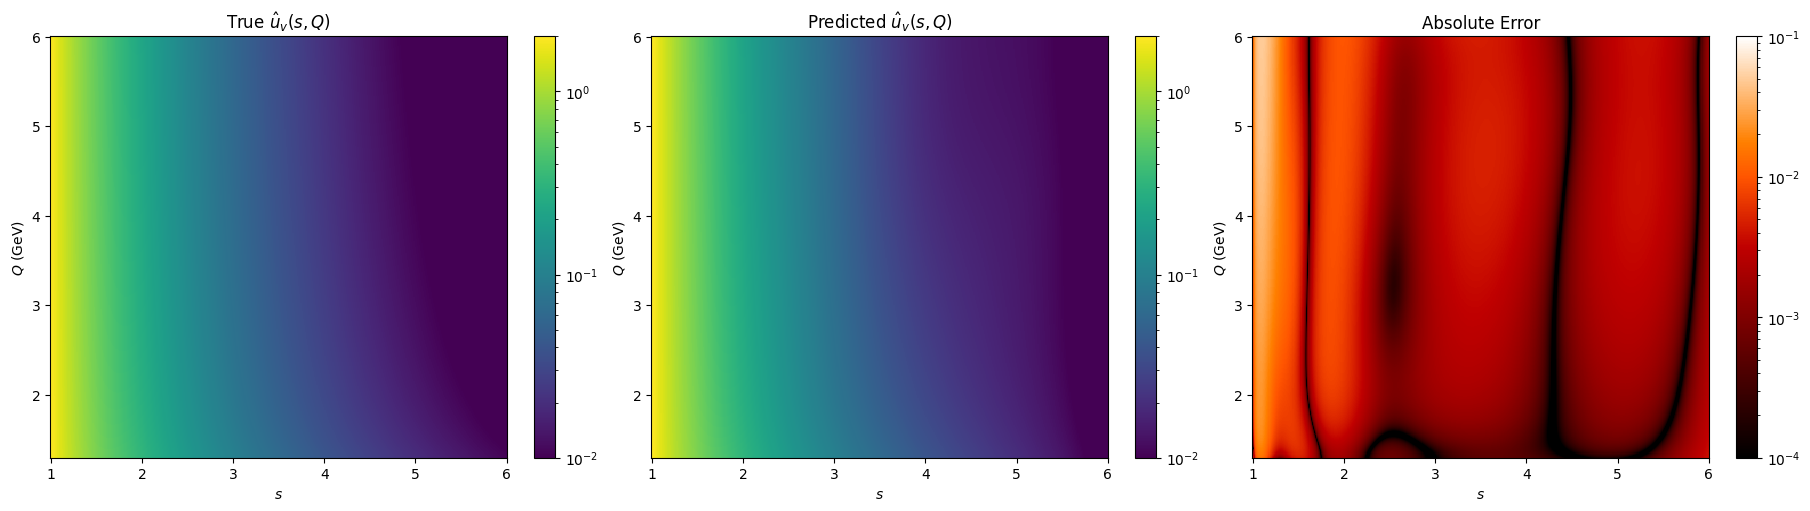

In [ ]:
  from matplotlib.colors import LogNorm

# Solution

# Grid for s and Q
s_vals = np.linspace(1, 6, 400)
Q_vals = np.linspace(1.3, 6, 400)
S, Q = np.meshgrid(s_vals, Q_vals)

# Compute true function values
Z = u_v_Mellin(S, Q)  # shape (200, 200)

# Predictions
# Prepare input data for model: flatten and stack S and Q as (N, 2)
S_flat = S.flatten()
Q_flat = Q.flatten()
inputs = tf.convert_to_tensor(np.stack([S_flat, Q_flat], axis=1), dtype=tf.float32)

# Predict using the trained model
Z_pred_flat = model2(inputs).numpy().flatten()

# Reshape back to the original 2D shape
Z_pred = Z_pred_flat.reshape(S.shape)

# Compute absolute error and max for scaling plot
Z_error = np.abs(Z - Z_pred)
max_abs_err = np.max(np.abs(Z_error))

# Set color scale so that pred. and true graph are the same
vmin = 1e-2
vmax = 2

fig, axs = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# 1. True function
pcm1 = axs[0].pcolormesh(S, Q, Z, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
axs[0].set_title('True $\\hat{u}_v(s, Q)$')
axs[0].set_xlabel('$s$')
axs[0].set_ylabel('$Q$ (GeV)')

# 2. Predicted function
pcm2 = axs[1].pcolormesh(S, Q, Z_pred, shading='auto', cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
axs[1].set_title('Predicted $\\hat{u}_v(s, Q)$')
axs[1].set_xlabel('$s$')
axs[1].set_ylabel('$Q$ (GeV)')

# 3. Error
pcm3 = axs[2].pcolormesh(S, Q, Z_error, shading='auto', cmap='gist_heat',
                         norm=LogNorm(vmin=1e-4, vmax=1e-1)
                         )
axs[2].set_title('Absolute Error')
axs[2].set_xlabel('$s$')
axs[2].set_ylabel('$Q$ (GeV)')

# Add colorbars for each plot
fig.colorbar(pcm1, ax=axs[0])
fig.colorbar(pcm2, ax=axs[1])
fig.colorbar(pcm3, ax=axs[2])

plt.show()